# Toroidal Token Generation with Bidirectional Propagation

This notebook trains a **token generation model** using a toroidal lattice with bidirectional propagation:

### Architecture
```
Input Token → Embedding → Bidirectional Torus Propagation → Output Logits → Next Token
```

### Key Features
1. **Forward propagation**: Signal spreads in the +θ, +φ direction
2. **Reverse propagation**: Signal spreads in the -θ, -φ direction simultaneously
3. **Token prediction**: Cross-entropy loss for next-token prediction
4. **Autoregressive generation**: Generate text token-by-token

The torus wrap-around topology means both signals can travel around and meet from opposite sides!

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
import json
from typing import List, Dict, Optional, Tuple, Set

from toroidal_lattice import (
    ToroidalLatticeVisualizer,
    ToroidalDifferentiableLattice,
    ToroidalCell,
    create_toroidal_lattice
)
from cell import DEVICE

# Import MPS/CUDA kernels for accelerated propagation
try:
    from kernels import create_kernels, PulsePropagationKernels, get_backend
    KERNELS_AVAILABLE = True
    KERNELS = create_kernels(torch.device(DEVICE))
    print(f"Custom kernels loaded: {get_backend()} backend")
except ImportError as e:
    KERNELS_AVAILABLE = False
    KERNELS = None
    print(f"Custom kernels not available: {e}")

print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

PulsePropagationKernels initialized with backend: mps
Custom kernels loaded: mps backend
Using device: mps
PyTorch version: 2.10.0


## 1. Load Dolma Embeddings

In [3]:
def load_word2vec_embeddings(filepath: str, max_embeddings: int = None, skip_header: bool = False):
    """
    Load word embeddings from a text file (word2vec format).
    Format: word dim1 dim2 dim3 ... dimN
    """
    words = []
    embeddings = []
    
    print(f"Loading embeddings from {filepath}...")
    
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        for i, line in enumerate(f):
            if skip_header and i == 0:
                continue
            
            parts = line.strip().split()
            if len(parts) < 10:  # Skip malformed lines
                continue
            
            word = parts[0]
            try:
                vector = [float(x) for x in parts[1:]]
                words.append(word)
                embeddings.append(vector)
            except ValueError:
                continue
            
            if max_embeddings and len(words) >= max_embeddings:
                break
            
            if len(words) % 10000 == 0:
                print(f"  Loaded {len(words):,} embeddings...")
    
    embeddings = np.array(embeddings, dtype=np.float32)
    print(f"Loaded {len(words):,} embeddings of dimension {embeddings.shape[1]}")
    
    return words, embeddings

# Load Dolma embeddings
DOLMA_PATH = "/Users/iglidden/Downloads/dolma_300_2024_1.2M.100_combined.txt"
MAX_EMBEDDINGS = 500  # Limit for faster training #40000

words, dolma_embeddings = load_word2vec_embeddings(DOLMA_PATH, max_embeddings=MAX_EMBEDDINGS)

# Normalize embeddings
norms = np.linalg.norm(dolma_embeddings, axis=1, keepdims=True)
dolma_embeddings = dolma_embeddings / (norms + 1e-8)

print(f"\nEmbedding stats:")
print(f"  Shape: {dolma_embeddings.shape}")
print(f"  Sample words: {words[:10]}")

Loading embeddings from /Users/iglidden/Downloads/dolma_300_2024_1.2M.100_combined.txt...
Loaded 500 embeddings of dimension 300

Embedding stats:
  Shape: (500, 300)
  Sample words: ['.', 'the', ',', 'and', 'to', 'of', 'a', 'in', 'i', 'is']


In [4]:
# Configuration
EMBEDDING_DIM = dolma_embeddings.shape[1]
N_EMBEDDINGS = len(dolma_embeddings)

print(f"Training configuration:")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  Number of embeddings: {N_EMBEDDINGS:,}")

Training configuration:
  Embedding dimension: 300
  Number of embeddings: 500


## 2. Create Toroidal Lattice

In [5]:
# Create toroidal lattice
N_THETA = 20   # Cells around the tube
N_PHI = 40     # Cells around the torus
MAJOR_RADIUS = 4.0
MINOR_RADIUS = 1.5

torus = create_toroidal_lattice(
    n_theta=N_THETA,
    n_phi=N_PHI,
    major_radius=MAJOR_RADIUS,
    minor_radius=MINOR_RADIUS,
    storage_path="./toroidal_dolma_storage"
)

print(f"\nToroidal Lattice Created:")
print(f"  Cells around tube (θ): {torus.n_theta}")
print(f"  Cells around torus (φ): {torus.n_phi}")
print(f"  Total cells: {torus._total_cells}")
print(f"  Torus dimensions: R={torus.major_radius}, r={torus.minor_radius}")

Loading torus blueprint from toroidal_dolma_storage/torus_blueprint_T20_P40.json

Toroidal Lattice Created:
  Cells around tube (θ): 20
  Cells around torus (φ): 40
  Total cells: 800
  Torus dimensions: R=4.0, r=1.5


## 3. Bidirectional Propagation Module

In [22]:
class BidirectionalToroidalLattice(nn.Module):
    """
    Toroidal lattice with bidirectional propagation.
    
    Forward and reverse signals propagate simultaneously:
    - Forward: spreads in +θ, +φ direction
    - Reverse: spreads in -θ, -φ direction
    
    Both signals interact where they meet on the torus surface.
    
    Uses MPS/CUDA kernels when available for GPU acceleration.
    """
    
    def __init__(self, torus_lattice: ToroidalLatticeVisualizer, max_steps: int = 10,
                 use_kernels: bool = True):
        super().__init__()
        self.torus = torus_lattice
        self.max_steps = max_steps
        self.device = torus_lattice.device
        
        # Use MPS/CUDA kernels if available
        self.use_kernels = use_kernels and KERNELS_AVAILABLE
        self.kernels = KERNELS if self.use_kernels else None
        if self.use_kernels:
            print(f"BidirectionalToroidalLattice using {self.kernels.backend} kernels")
        
        # Learnable parameters for forward propagation
        self.forward_step_weights = nn.Parameter(torch.ones(max_steps) / max_steps)
        self.forward_decay = nn.Parameter(torch.tensor(0.85))
        
        # Learnable parameters for reverse propagation
        self.reverse_step_weights = nn.Parameter(torch.ones(max_steps) / max_steps)
        self.reverse_decay = nn.Parameter(torch.tensor(0.85))
        
        # Interaction parameters (how forward and reverse combine)
        self.interaction_weight = nn.Parameter(torch.tensor(0.5))
        
        # Propagation threshold
        self.threshold = nn.Parameter(torch.tensor(0.01))
        
        # Learnable bounce angles for MPS kernel acceleration  
        self.bounce_angles = nn.Parameter(torch.randn(torus_lattice._total_cells, 3) * 0.1)
        
        # Build directed adjacency matrices
        self._build_directed_adjacency()
    
    def _build_directed_adjacency(self):
        """Build forward and reverse adjacency for directed propagation."""
        n_cells = self.torus._total_cells
        
        # Forward adjacency: +θ, +φ neighbors
        forward_adj = {}
        # Reverse adjacency: -θ, -φ neighbors
        reverse_adj = {}
        
        for idx in range(n_cells):
            ti, pi = self.torus.get_theta_phi(idx)
            
            # Forward neighbors (+θ, +φ, and diagonals)
            forward_neighbors = [
                self.torus.get_idx_from_theta_phi((ti + 1) % self.torus.n_theta, pi),
                self.torus.get_idx_from_theta_phi(ti, (pi + 1) % self.torus.n_phi),
                self.torus.get_idx_from_theta_phi((ti + 1) % self.torus.n_theta, (pi + 1) % self.torus.n_phi),
            ]
            forward_adj[idx] = forward_neighbors
            
            # Reverse neighbors (-θ, -φ, and diagonals)
            reverse_neighbors = [
                self.torus.get_idx_from_theta_phi((ti - 1) % self.torus.n_theta, pi),
                self.torus.get_idx_from_theta_phi(ti, (pi - 1) % self.torus.n_phi),
                self.torus.get_idx_from_theta_phi((ti - 1) % self.torus.n_theta, (pi - 1) % self.torus.n_phi),
            ]
            reverse_adj[idx] = reverse_neighbors
        
        self.forward_adj = forward_adj
        self.reverse_adj = reverse_adj
    
    def _propagate_direction(
        self,
        entry_probs: torch.Tensor,
        entry_indices: List[List[int]],
        adjacency: Dict[int, List[int]],
        decay: torch.Tensor,
        step_weights: torch.Tensor
    ) -> Tuple[torch.Tensor, List[int], List[torch.Tensor]]:
        """
        Propagate in one direction (forward or reverse).
        """
        batch_size = entry_probs.shape[0]
        device = entry_probs.device
        
        # Collect entry points
        all_entry = set()
        for indices in entry_indices:
            all_entry.update(indices)
        
        # Create entry cells
        touched = set(all_entry)
        for idx in all_entry:
            self.torus._get_or_create_cell(idx)
        
        touched_list = sorted(touched)
        idx_to_pos = {idx: i for i, idx in enumerate(touched_list)}
        
        # Initialize
        current = torch.zeros(batch_size, len(touched_list), device=device)
        for i, idx in enumerate(touched_list):
            current[:, i] = entry_probs[:, idx]
        
        step_outputs = []
        decay_val = torch.clamp(decay, 0.5, 0.99)
        threshold = torch.clamp(self.threshold, 0.001, 0.1).item()
        
        for step in range(self.max_steps):
            # Find active cells
            with torch.no_grad():
                max_act = current.max(dim=0)[0]
                active_pos = torch.where(max_act > threshold)[0].tolist()
            
            if not active_pos:
                step_outputs.append(current.clone())
                continue
            
            # Expand to neighbors
            new_cells = set()
            for pos in active_pos:
                cell_idx = touched_list[pos]
                neighbors = adjacency.get(cell_idx, [])
                for n_idx in neighbors:
                    if n_idx not in touched:
                        new_cells.add(n_idx)
                        self.torus._get_or_create_cell(n_idx)
            
            if new_cells:
                touched.update(new_cells)
                touched_list = sorted(touched)
                idx_to_pos = {idx: i for i, idx in enumerate(touched_list)}
                
                old = current
                current = torch.zeros(batch_size, len(touched_list), device=device)
                for old_pos, old_idx in enumerate(sorted(touched - new_cells)):
                    new_pos = idx_to_pos[old_idx]
                    current[:, new_pos] = old[:, old_pos]
            
            # Build local adjacency
            n_touched = len(touched_list)
            adj_matrix = torch.zeros(n_touched, n_touched, device=device)
            
            for i, idx in enumerate(touched_list):
                neighbors = adjacency.get(idx, [])
                for n_idx in neighbors:
                    if n_idx in idx_to_pos:
                        j = idx_to_pos[n_idx]
                        adj_matrix[i, j] = 1.0
            
            row_sum = adj_matrix.sum(dim=1, keepdim=True) + 1e-8
            adj_matrix = adj_matrix / row_sum
            
            # Propagate using MPS/CUDA kernels if available
            if self.use_kernels and self.kernels is not None:
                # Use kernel-accelerated propagation
                adj_matrix = adj_matrix.contiguous()
                current = current.contiguous()
                propagated = self.kernels.propagate_state(current, adj_matrix.T)
                
                # Get bounce angles for touched cells and apply transform
                touched_indices_tensor = torch.tensor(touched_list, device=device)
                touched_bounce = self.bounce_angles[touched_indices_tensor].contiguous()
                propagated = self.kernels.apply_bounce_transform(propagated, touched_bounce)
                
                # Fused decay
                next_act = (0.3 * current + 0.7 * propagated) * decay_val
            else:
                # Fallback: standard PyTorch
                next_act = (
                    0.3 * current +
                    0.7 * torch.matmul(current, adj_matrix)
                ) * decay_val
            
            # Re-inject at entry points
            for i, idx in enumerate(touched_list):
                if idx in all_entry:
                    next_act[:, i] = next_act[:, i] + entry_probs[:, idx] * 0.1
            
            current = next_act
            step_outputs.append(current.clone())
        
        # Weighted combination using MPS kernels if available
        weights = torch.softmax(step_weights, dim=0)
        max_cells = len(touched_list)
        
        # Pad all outputs to same size
        padded_outputs = []
        for out in step_outputs:
            if out.shape[1] < max_cells:
                padded = torch.zeros(batch_size, max_cells, device=device)
                padded[:, :out.shape[1]] = out
                padded_outputs.append(padded)
            else:
                padded_outputs.append(out)
        
        if self.use_kernels and self.kernels is not None and len(padded_outputs) > 0:
            # Stack and use kernel for efficient weighted sum
            history_tensor = torch.stack(padded_outputs, dim=0)  # (n_steps, batch, cells)
            final = self.kernels.weighted_history_sum(history_tensor, weights[:len(padded_outputs)])
        else:
            # Fallback: loop-based
            final = torch.zeros(batch_size, max_cells, device=device)
            for i, out in enumerate(padded_outputs):
                final = final + weights[i] * out
        
        return final, touched_list, step_outputs
    
    def forward(
        self,
        entry_probs: torch.Tensor,
        entry_indices: List[List[int]]
    ) -> Tuple[torch.Tensor, torch.Tensor, List[int], Dict]:
        """
        Bidirectional propagation: forward and reverse simultaneously.
        
        Returns:
            combined_state: Combined forward + reverse activations
            interaction_state: Where forward and reverse meet
            touched_indices: All touched cell indices
            history: Propagation history
        """
        # Forward propagation
        forward_state, forward_touched, forward_history = self._propagate_direction(
            entry_probs, entry_indices,
            self.forward_adj, self.forward_decay, self.forward_step_weights
        )
        
        # Reverse propagation
        reverse_state, reverse_touched, reverse_history = self._propagate_direction(
            entry_probs, entry_indices,
            self.reverse_adj, self.reverse_decay, self.reverse_step_weights
        )
        
        # Combine touched cells
        all_touched = set(forward_touched) | set(reverse_touched)
        all_touched_list = sorted(all_touched)
        
        # Create unified state tensors
        batch_size = entry_probs.shape[0]
        device = entry_probs.device
        n_cells = len(all_touched_list)
        
        unified_forward = torch.zeros(batch_size, n_cells, device=device)
        unified_reverse = torch.zeros(batch_size, n_cells, device=device)
        
        # Map forward state to unified
        for i, idx in enumerate(forward_touched):
            if i < forward_state.shape[1]:
                new_pos = all_touched_list.index(idx)
                unified_forward[:, new_pos] = forward_state[:, i]
        
        # Map reverse state to unified
        for i, idx in enumerate(reverse_touched):
            if i < reverse_state.shape[1]:
                new_pos = all_touched_list.index(idx)
                unified_reverse[:, new_pos] = reverse_state[:, i]
        
        # Combine forward and reverse
        # Interaction: where both signals are present, they reinforce
        interaction_weight = torch.sigmoid(self.interaction_weight)
        
        # Element-wise product shows where both signals meet
        interaction = unified_forward * unified_reverse
        
        # Combined state: sum + interaction bonus
        combined = (
            unified_forward + unified_reverse + 
            interaction_weight * interaction
        )
        
        history = {
            'forward_touched': len(forward_touched),
            'reverse_touched': len(reverse_touched),
            'total_touched': len(all_touched_list),
            'interaction_strength': interaction.mean().item()
        }
        
        return combined, interaction, all_touched_list, history


print("BidirectionalToroidalLattice defined")

BidirectionalToroidalLattice defined


## 4. Toroidal Embedding Memory Model

In [ ]:
class ToroidalSignalEncoder(nn.Module):
    """
    Maps input embeddings to entry points on the torus.
    Entry points = embedding dimension (1:1 mapping).
    """
    
    def __init__(self, input_dim: int, total_cells: int, hidden_dim: int = 256, dropout: float = 0.2):
        super().__init__()
        self.input_dim = input_dim
        self.total_cells = total_cells
        self.n_entry_points = input_dim  # 1:1 mapping
        
        # Maps input to cell selection
        self.entry_selector = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, total_cells),
        )
        
        self.temperature = nn.Parameter(torch.tensor(0.5))
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, List[List[int]]]:
        """
        Args:
            x: Input embeddings (batch_size, input_dim)
        Returns:
            entry_probs: Soft selection over cells (batch_size, total_cells)
            entry_strengths: Input values as strengths (batch_size, input_dim)
            entry_indices: Top-k cell indices per sample
        """
        logits = self.entry_selector(x)
        temp = self.temperature.abs() + 0.1
        entry_probs = torch.softmax(logits / temp, dim=-1)
        
        # Input values directly as entry strengths
        entry_strengths = torch.abs(x)
        
        # Top-k entry indices
        with torch.no_grad():
            _, top_idx = torch.topk(logits, self.n_entry_points, dim=-1)
            entry_indices = top_idx.cpu().tolist()
        
        return entry_probs, entry_strengths, entry_indices


class DynamicToroidalMemory(nn.Module):
    """
    Dynamic memory that grows as torus cells are touched.
    """
    
    def __init__(self, embedding_dim: int, memory_slots: int = 32, device='cpu'):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.memory_slots = memory_slots
        self.device = device
        
        self.register_buffer('_cell_embeddings', torch.zeros(0, embedding_dim))
        self.register_buffer('_memory_keys', torch.zeros(0, memory_slots))
        self.register_buffer('_memory_values', torch.zeros(0, memory_slots, embedding_dim))
        
        self.allocated_cells: Dict[int, int] = {}
    
    def ensure_cell_memory(self, cell_indices: List[int]):
        """Allocate memory for new cells."""
        new_cells = [idx for idx in cell_indices if idx not in self.allocated_cells]
        
        if new_cells:
            n_new = len(new_cells)
            current_size = len(self.allocated_cells)
            
            new_emb = torch.randn(n_new, self.embedding_dim, device=self.device) * 0.1
            new_keys = torch.randn(n_new, self.memory_slots, device=self.device) * 0.1
            new_vals = torch.randn(n_new, self.memory_slots, self.embedding_dim, device=self.device) * 0.1
            
            self._cell_embeddings = torch.cat([self._cell_embeddings, new_emb], dim=0)
            self._memory_keys = torch.cat([self._memory_keys, new_keys], dim=0)
            self._memory_values = torch.cat([self._memory_values, new_vals], dim=0)
            
            for i, idx in enumerate(new_cells):
                self.allocated_cells[idx] = current_size + i
    
    def read(self, state: torch.Tensor, active_indices: List[int]) -> torch.Tensor:
        """Read from memory based on activation state."""
        if len(active_indices) == 0:
            return torch.zeros(state.shape[0], self.embedding_dim, device=self.device)
        
        self.ensure_cell_memory(active_indices)
        
        slots = [self.allocated_cells[idx] for idx in active_indices]
        cell_emb = self._cell_embeddings[slots]
        mem_keys = self._memory_keys[slots]
        mem_vals = self._memory_values[slots]
        
        attention = torch.softmax(
            torch.einsum('bc,cm->bcm', state, mem_keys), dim=-1
        )
        slot_contrib = torch.einsum('bcm,cme->bce', attention, mem_vals)
        direct_contrib = torch.einsum('bc,ce->be', state, cell_emb)
        
        return direct_contrib + (slot_contrib * state.unsqueeze(-1)).sum(dim=1)
    
    def get_n_allocated(self) -> int:
        return len(self.allocated_cells)


class ToroidalRetriever(nn.Module):
    """Transforms propagation state to output embedding."""
    
    def __init__(self, max_cells: int, embedding_dim: int, hidden_dim: int = 256, dropout: float = 0.2):
        super().__init__()
        self.max_cells = max_cells
        self.embedding_dim = embedding_dim
        
        self.retriever = nn.Sequential(
            nn.Linear(max_cells, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embedding_dim)
        )
    
    def forward(self, state: torch.Tensor) -> torch.Tensor:
        batch_size = state.shape[0]
        n_cells = state.shape[1]
        
        if n_cells < self.max_cells:
            padded = torch.zeros(batch_size, self.max_cells, device=state.device)
            padded[:, :n_cells] = state
            state = padded
        elif n_cells > self.max_cells:
            state = state[:, :self.max_cells]
        
        return self.retriever(state)


class BidirectionalToroidalMemory(nn.Module):
    """
    Complete bidirectional toroidal memory system.
    
    Architecture:
    1. INPUT → SignalEncoder → Entry Points
    2. Entry Points → Bidirectional Propagation (forward + reverse)
    3. Combined State → Memory Read → Retrieved Embedding
    """
    
    def __init__(
        self,
        torus_lattice: ToroidalLatticeVisualizer,
        embedding_dim: int,
        max_steps: int = 14,
        max_active_cells: int = 3000,
        hidden_dim: int = 300,
        memory_slots: int = 32,
        dropout: float = 0.2
    ):
        super().__init__()
        self.torus = torus_lattice
        self.embedding_dim = embedding_dim
        self.max_active_cells = max_active_cells
        self.device = torus_lattice.device
        
        # Signal encoder
        self.signal_encoder = ToroidalSignalEncoder(
            embedding_dim, torus_lattice._total_cells, hidden_dim, dropout
        )
        
        # Bidirectional propagation
        self.bidirectional_lattice = BidirectionalToroidalLattice(torus_lattice, max_steps)
        
        # Dynamic memory
        self.memory = DynamicToroidalMemory(embedding_dim, memory_slots, self.device)
        
        # Retriever
        self.retriever = ToroidalRetriever(max_active_cells, embedding_dim, hidden_dim, dropout)
        
        self.to(self.device)
        
        self._total_cells_touched = 0
        self._forward_count = 0
    
    def forward(self, input_embedding: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, List[int]]:
        """
        Forward pass with bidirectional propagation.
        """
        input_embedding = input_embedding.to(self.device)
        self._forward_count += 1
        
        # Encode to entry points
        entry_probs, entry_strengths, entry_indices = self.signal_encoder(input_embedding)
        
        # Bidirectional propagation
        combined_state, interaction, touched_indices, history = self.bidirectional_lattice(
            entry_probs, entry_indices
        )
        
        self._total_cells_touched += history['total_touched']
        
        # Read from memory
        memory_out = self.memory.read(combined_state, touched_indices)
        
        # Final retrieval
        retriever_out = self.retriever(combined_state)
        
        # Combine
        retrieved = memory_out + retriever_out
        retrieved = retrieved / (torch.norm(retrieved, dim=1, keepdim=True) + 1e-8)
        
        return retrieved, combined_state, touched_indices
    
    def get_stats(self) -> Dict:
        return {
            'cells_in_torus': len(self.torus.sparse_cells),
            'memory_allocated': self.memory.get_n_allocated(),
            'total_touched': self._total_cells_touched,
            'forward_passes': self._forward_count,
            'avg_touched_per_forward': self._total_cells_touched / max(1, self._forward_count),
            'blueprint_total': self.torus._total_cells
        }


print("BidirectionalToroidalMemory defined")

BidirectionalToroidalMemory defined


In [24]:
class ToroidalTokenGenerator(nn.Module):
    """
    Token generation model using bidirectional toroidal propagation.
    
    Architecture:
    1. Input tokens → Token Embeddings
    2. Embeddings → Bidirectional Propagation on Torus
    3. Propagation State → Output Token Logits
    
    Supports next-token prediction for language modeling.
    """
    
    def __init__(
        self,
        torus_lattice: ToroidalLatticeVisualizer,
        vocab_size: int,
        embedding_dim: int,
        max_steps: int = 10,
        max_active_cells: int = 400,
        hidden_dim: int = 256,
        memory_slots: int = 32,
        dropout: float = 0.2,
        pretrained_embeddings: torch.Tensor = None
    ):
        super().__init__()
        self.torus = torus_lattice
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_active_cells = max_active_cells
        self.device = torus_lattice.device
        
        # Token embedding layer
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.token_embedding.weight.data.copy_(pretrained_embeddings)
            print(f"Loaded pretrained embeddings: {pretrained_embeddings.shape}")
        
        # Signal encoder (embedding → torus entry points)
        self.signal_encoder = ToroidalSignalEncoder(
            embedding_dim, torus_lattice._total_cells, hidden_dim, dropout
        )
        
        # Bidirectional propagation
        self.bidirectional_lattice = BidirectionalToroidalLattice(torus_lattice, max_steps)
        
        # Dynamic memory
        self.memory = DynamicToroidalMemory(embedding_dim, memory_slots, self.device)
        
        # Output projection: propagation state → token logits
        self.output_projection = nn.Sequential(
            nn.Linear(max_active_cells, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, vocab_size)  # Output logits over vocabulary
        )
        
        self.to(self.device)
        
        self._total_cells_touched = 0
        self._forward_count = 0
    
    def forward(self, input_tokens: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, List[int]]:
        """
        Forward pass: input tokens → output token logits.
        
        Args:
            input_tokens: Token indices (batch_size,) or (batch_size, seq_len)
        
        Returns:
            logits: Token logits (batch_size, vocab_size)
            propagated_state: Propagation state for visualization
            touched_indices: Cells touched during propagation
        """
        input_tokens = input_tokens.to(self.device)
        self._forward_count += 1
        
        # Handle sequence input - use last token or mean pool
        if input_tokens.dim() == 2:
            # Sequence input: embed all tokens and mean pool
            embeddings = self.token_embedding(input_tokens)  # (batch, seq, embed_dim)
            input_embedding = embeddings.mean(dim=1)  # (batch, embed_dim)
        else:
            # Single token input
            input_embedding = self.token_embedding(input_tokens)  # (batch, embed_dim)
        
        # Encode to entry points
        entry_probs, entry_strengths, entry_indices = self.signal_encoder(input_embedding)
        
        # Bidirectional propagation
        combined_state, interaction, touched_indices, history = self.bidirectional_lattice(
            entry_probs, entry_indices
        )
        
        self._total_cells_touched += history['total_touched']
        
        # Pad/truncate state to max_active_cells
        batch_size = input_tokens.shape[0] if input_tokens.dim() == 1 else input_tokens.shape[0]
        n_cells = combined_state.shape[1]
        
        if n_cells < self.max_active_cells:
            padded = torch.zeros(batch_size, self.max_active_cells, device=self.device)
            padded[:, :n_cells] = combined_state
            combined_state = padded
        elif n_cells > self.max_active_cells:
            combined_state = combined_state[:, :self.max_active_cells]
        
        # Project to vocabulary logits
        logits = self.output_projection(combined_state)
        
        return logits, combined_state, touched_indices
    
    def generate(self, input_tokens: torch.Tensor, max_new_tokens: int = 10, 
                 temperature: float = 1.0, top_k: int = 50) -> torch.Tensor:
        """
        Generate new tokens autoregressively.
        
        Args:
            input_tokens: Starting token indices (batch_size,) or (batch_size, seq_len)
            max_new_tokens: Number of tokens to generate
            temperature: Sampling temperature (higher = more random)
            top_k: Only sample from top-k most likely tokens
        
        Returns:
            generated: Generated token indices (batch_size, max_new_tokens)
        """
        self.eval()
        generated = []
        
        current_input = input_tokens
        
        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Get logits for next token
                logits, _, _ = self.forward(current_input)
                
                # Apply temperature
                logits = logits / temperature
                
                # Top-k filtering
                if top_k > 0:
                    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
                    logits[indices_to_remove] = float('-inf')
                
                # Sample from distribution
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).squeeze(-1)
                
                generated.append(next_token)
                
                # Update input for next iteration
                if current_input.dim() == 2:
                    current_input = torch.cat([current_input, next_token.unsqueeze(1)], dim=1)
                else:
                    current_input = next_token
        
        return torch.stack(generated, dim=1)
    
    def get_stats(self) -> Dict:
        return {
            'cells_in_torus': len(self.torus.sparse_cells),
            'memory_allocated': self.memory.get_n_allocated(),
            'total_touched': self._total_cells_touched,
            'forward_passes': self._forward_count,
            'avg_touched_per_forward': self._total_cells_touched / max(1, self._forward_count),
            'blueprint_total': self.torus._total_cells,
            'vocab_size': self.vocab_size
        }


print("ToroidalTokenGenerator defined")

ToroidalTokenGenerator defined


## 5. Create Model and Data

In [9]:
# NOTE: Run cell 14 (data prep) FIRST to define VOCAB_SIZE and embeddings_tensor
# This cell creates the TOKEN GENERATION model

BidirectionalToroidalLattice using mps kernels

Bidirectional Toroidal Memory Model:
  Embedding dim: 300
  Entry points: 300 (1:1 mapping)
  Max propagation steps: 14
  Max active cells: 10
  Torus cells: 800
  Total parameters: 218,317
  Kernel backend: mps


In [25]:
# Prepare TOKEN data for next-token prediction
# Each sample: input token → predict next token

# Create vocabulary from words
VOCAB_SIZE = len(words)
word_to_idx = {w: i for i, w in enumerate(words)}
idx_to_word = {i: w for i, w in enumerate(words)}

# Create token pairs: (token_i, token_i+1) for next-token prediction
# We'll use random token pairs from the vocabulary
np.random.seed(42)
n_pairs = min(100000, VOCAB_SIZE * 10)  # Create pairs

# Generate random input-target pairs (simulating token sequences)
input_tokens = torch.randint(0, VOCAB_SIZE, (n_pairs,))
# Target is a "related" token (for now, random - in real use, would be actual next tokens)
target_tokens = torch.randint(0, VOCAB_SIZE, (n_pairs,))

# Also store embeddings for the model
embeddings_tensor = torch.tensor(dolma_embeddings, dtype=torch.float32)

# Train/val split
n_train = int(0.9 * n_pairs)
train_inputs = input_tokens[:n_train]
train_targets = target_tokens[:n_train]
val_inputs = input_tokens[n_train:]
val_targets = target_tokens[n_train:]

train_dataset = TensorDataset(train_inputs, train_targets)
val_dataset = TensorDataset(val_inputs, val_targets)

BATCH_SIZE = 64
EPOCH_FRACTION = 100  # Only use 25% of data per epoch

# Use RandomSampler to sample 25% of training data each epoch
from torch.utils.data import RandomSampler
n_samples_per_epoch = int(len(train_dataset) * EPOCH_FRACTION)
train_sampler = RandomSampler(train_dataset, replacement=True, num_samples=n_samples_per_epoch)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print(f"Token data prepared:")
print(f"  Vocabulary size: {VOCAB_SIZE:,}")
print(f"  Total pairs: {n_pairs:,}")
print(f"  Train dataset: {len(train_dataset):,}")
print(f"  Train per epoch: {n_samples_per_epoch:,} ({EPOCH_FRACTION*100:.0f}%)")
print(f"  Val: {len(val_dataset):,}")
print(f"  Sample words: {[idx_to_word[i.item()] for i in input_tokens[:5]]}")

Token data prepared:
  Vocabulary size: 500
  Total pairs: 5,000
  Train dataset: 4,500
  Train per epoch: 450,000 (10000%)
  Val: 500
  Sample words: ['we', 'during', 'know', 'offer', 'still']


In [ ]:
# Create TOKEN GENERATION model
MAX_STEPS = 12
MAX_ACTIVE_CELLS = 500
MEMORY_SLOTS = 32
HIDDEN_DIM = 256

model = ToroidalTokenGenerator(
    torus_lattice=torus,
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    max_steps=MAX_STEPS,
    max_active_cells=MAX_ACTIVE_CELLS,
    hidden_dim=HIDDEN_DIM,
    memory_slots=MEMORY_SLOTS,
    dropout=0.2,
    pretrained_embeddings=embeddings_tensor  # Use Dolma embeddings
)

print(f"\nToroidal Token Generator Model:")
print(f"  Vocabulary size: {VOCAB_SIZE:,}")
print(f"  Embedding dim: {EMBEDDING_DIM}")
print(f"  Max propagation steps: {MAX_STEPS}")
print(f"  Max active cells: {MAX_ACTIVE_CELLS}")
print(f"  Torus cells: {torus._total_cells}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Kernel backend: {KERNELS.backend if KERNELS_AVAILABLE else 'PyTorch (no custom kernels)'}")

Loaded pretrained embeddings: torch.Size([1500, 300])
BidirectionalToroidalLattice using mps kernels

Toroidal Token Generator Model:
  Vocabulary size: 1,500
  Embedding dim: 300
  Max propagation steps: 12
  Max active cells: 500
  Torus cells: 800
  Total parameters: 1,382,473
  Kernel backend: mps


## 6. Training

In [26]:
# Training config for TOKEN GENERATION
N_EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3
EARLY_STOP_PATIENCE = 10

# Loss function: Cross-entropy for next-token prediction
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(f"Training config (Token Generation):")
print(f"  Epochs: {N_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Loss: CrossEntropyLoss")

Training config (Token Generation):
  Epochs: 50
  Learning rate: 0.0001
  Weight decay: 0.001
  Loss: CrossEntropyLoss


In [13]:
def train_epoch(model, loader, optimizer, device):
    """Train one epoch for token generation."""
    model.train()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    n_batches = 0
    
    for input_tokens, target_tokens in loader:
        input_tokens = input_tokens.to(device)
        target_tokens = target_tokens.to(device)
        optimizer.zero_grad()
        
        # Forward pass: input tokens → logits
        logits, _, _ = model(input_tokens)
        
        # Cross-entropy loss
        loss = criterion(logits, target_tokens)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # Compute accuracy
        predictions = logits.argmax(dim=-1)
        total_correct += (predictions == target_tokens).sum().item()
        total_tokens += target_tokens.size(0)
        
        total_loss += loss.item()
        n_batches += 1
    
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0
    return total_loss / n_batches, accuracy


def validate(model, loader, device):
    """Validate token generation."""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    n_batches = 0
    
    with torch.no_grad():
        for input_tokens, target_tokens in loader:
            input_tokens = input_tokens.to(device)
            target_tokens = target_tokens.to(device)
            
            # Forward pass
            logits, _, _ = model(input_tokens)
            
            # Loss
            loss = criterion(logits, target_tokens)
            
            # Accuracy
            predictions = logits.argmax(dim=-1)
            total_correct += (predictions == target_tokens).sum().item()
            total_tokens += target_tokens.size(0)
            
            total_loss += loss.item()
            n_batches += 1
    
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0
    return total_loss / n_batches, accuracy


print("Token generation training functions defined")

Token generation training functions defined


In [14]:
# Training loop for TOKEN GENERATION with CELL STATE UPDATES
print("="*60)
print("Starting Toroidal Token Generation Training")
print("="*60)

train_losses = []
train_accs = []
val_losses = []
val_accs = []
cell_state_history = []  # Track cell state changes
best_val_loss = float('inf')
best_val_acc = 0
epochs_without_improvement = 0
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

def update_cell_states(model, torus):
    """
    Sync learned parameters back to torus cells after each epoch.
    Updates bounce_angles and other learnable cell parameters.
    """
    # Get bounce angles from the bidirectional lattice
    bounce_angles = model.bidirectional_lattice.bounce_angles.detach().cpu().numpy()
    
    # Update touched cells with learned parameters
    updated_count = 0
    for idx in list(torus.sparse_cells.keys()):
        if idx < len(bounce_angles):
            cell = torus.sparse_cells[idx]
            cell.bounce_angles = bounce_angles[idx]
            cell.modified = True
            updated_count += 1
    
    return updated_count

def get_cell_state_stats(model, torus):
    """Get statistics about current cell states."""
    bounce_angles = model.bidirectional_lattice.bounce_angles.detach()
    
    # Get stats for touched cells only
    touched_indices = list(torus.sparse_cells.keys())
    if len(touched_indices) > 0:
        touched_angles = bounce_angles[touched_indices]
        return {
            'n_touched': len(touched_indices),
            'bounce_mean': touched_angles.mean().item(),
            'bounce_std': touched_angles.std().item(),
            'bounce_min': touched_angles.min().item(),
            'bounce_max': touched_angles.max().item(),
            'forward_decay': model.bidirectional_lattice.forward_decay.item(),
            'reverse_decay': model.bidirectional_lattice.reverse_decay.item(),
            'interaction_weight': torch.sigmoid(model.bidirectional_lattice.interaction_weight).item(),
        }
    return {'n_touched': 0}

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, DEVICE)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_loss, val_acc = validate(model, val_loader, DEVICE)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)
    
    # UPDATE CELL STATES after each epoch
    n_updated = update_cell_states(model, torus)
    cell_stats = get_cell_state_stats(model, torus)
    cell_state_history.append(cell_stats)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        epochs_without_improvement = 0
        
        # Save checkpoint with cell states
        Path('checkpoints').mkdir(exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'vocab_size': VOCAB_SIZE,
            'cell_stats': cell_stats,
        }, f'checkpoints/toroidal_token_gen_{timestamp}_best.pt')
        
        # Also save cell states to torus storage
        torus.save_modified_cells()
    else:
        epochs_without_improvement += 1
    
    # Print every epoch with cell state info
    stats = model.get_stats()
    lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1:3d}/{N_EPOCHS} | "
          f"Loss: {train_loss:.4f}/{val_loss:.4f} | "
          f"Acc: {train_acc:.4f}/{val_acc:.4f} | "
          f"LR: {lr:.2e} | "
          f"Cells: {stats['cells_in_torus']} | "
          f"Bounce: {cell_stats['bounce_mean']:.3f}±{cell_stats['bounce_std']:.3f} | "
          f"Decay: {cell_stats['forward_decay']:.3f}/{cell_stats['reverse_decay']:.3f}")
    
    if epochs_without_improvement >= EARLY_STOP_PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("="*60)
print("Training Complete!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {best_val_acc:.4f}")

final_stats = model.get_stats()
final_cell_stats = get_cell_state_stats(model, torus)
print(f"\nFinal Stats:")
print(f"  Vocabulary size: {final_stats['vocab_size']:,}")
print(f"  Cells in torus: {final_stats['cells_in_torus']} / {final_stats['blueprint_total']}")
print(f"  Memory allocated: {final_stats['memory_allocated']}")
print(f"  Avg cells per forward: {final_stats['avg_touched_per_forward']:.1f}")
print(f"\nFinal Cell State:")
print(f"  Bounce angles: {final_cell_stats['bounce_mean']:.4f} ± {final_cell_stats['bounce_std']:.4f}")
print(f"  Bounce range: [{final_cell_stats['bounce_min']:.4f}, {final_cell_stats['bounce_max']:.4f}]")
print(f"  Forward decay: {final_cell_stats['forward_decay']:.4f}")
print(f"  Reverse decay: {final_cell_stats['reverse_decay']:.4f}")
print(f"  Interaction weight: {final_cell_stats['interaction_weight']:.4f}")

Starting Toroidal Token Generation Training


KeyboardInterrupt: 

## 7. Visualization

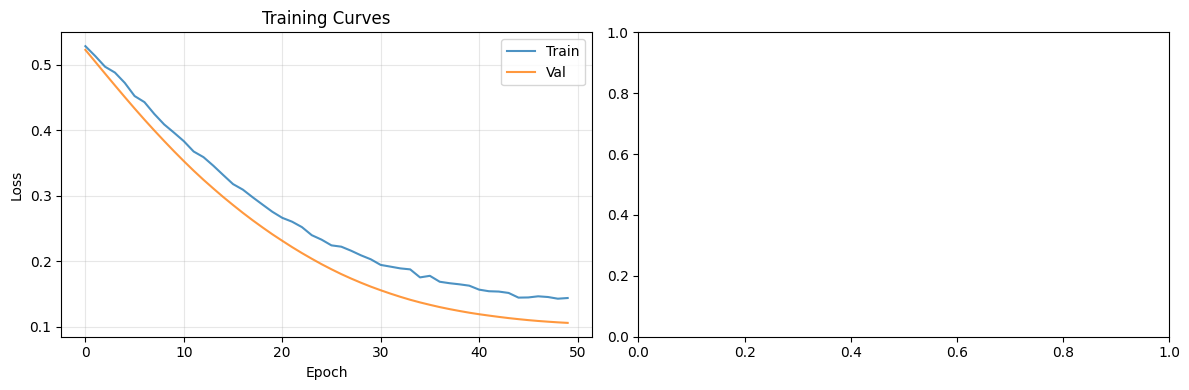

In [14]:
# Plot training curves for TOKEN GENERATION with CELL STATE tracking
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Row 1: Training metrics
# Loss curves
axes[0, 0].plot(train_losses, label='Train', alpha=0.8)
axes[0, 0].plot(val_losses, label='Val', alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (Cross-Entropy)')
axes[0, 0].set_title('Loss Curves')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(train_accs, label='Train', alpha=0.8)
axes[0, 1].plot(val_accs, label='Val', alpha=0.8)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Accuracy Curves')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Perplexity (exp of loss)
train_ppl = [np.exp(l) for l in train_losses]
val_ppl = [np.exp(l) for l in val_losses]
axes[0, 2].plot(train_ppl, label='Train', alpha=0.8)
axes[0, 2].plot(val_ppl, label='Val', alpha=0.8)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Perplexity')
axes[0, 2].set_title('Perplexity Curves')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Cell state evolution
# Bounce angles over time
bounce_means = [s['bounce_mean'] for s in cell_state_history]
bounce_stds = [s['bounce_std'] for s in cell_state_history]
axes[1, 0].plot(bounce_means, label='Mean', alpha=0.8)
axes[1, 0].fill_between(range(len(bounce_means)), 
                         [m-s for m,s in zip(bounce_means, bounce_stds)],
                         [m+s for m,s in zip(bounce_means, bounce_stds)],
                         alpha=0.3, label='±1 std')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Bounce Angle')
axes[1, 0].set_title('Bounce Angles Evolution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Decay rates over time
fwd_decays = [s['forward_decay'] for s in cell_state_history]
rev_decays = [s['reverse_decay'] for s in cell_state_history]
axes[1, 1].plot(fwd_decays, label='Forward', alpha=0.8)
axes[1, 1].plot(rev_decays, label='Reverse', alpha=0.8)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Decay Rate')
axes[1, 1].set_title('Propagation Decay Rates')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Interaction weight and cells touched
interaction_weights = [s['interaction_weight'] for s in cell_state_history]
n_touched = [s['n_touched'] for s in cell_state_history]
ax2 = axes[1, 2].twinx()
axes[1, 2].plot(interaction_weights, 'b-', label='Interaction', alpha=0.8)
ax2.plot(n_touched, 'r-', label='Cells Touched', alpha=0.8)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Interaction Weight', color='b')
ax2.set_ylabel('Cells Touched', color='r')
axes[1, 2].set_title('Interaction & Cell Count')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize touched cells on torus
fig_torus = torus.visualize_plotly(
    show_all_positions=True,
    cell_size=6,
    title=f"Toroidal Lattice - {len(torus.sparse_cells)} cells touched during training"
)
fig_torus.show()

In [17]:
# Test TOKEN GENERATION
model.eval()

test_words = ['king', 'queen', 'computer', 'software', 'happy', 'sad', 'the', 'and']
test_indices = [word_to_idx.get(w, 0) for w in test_words]
test_tokens = torch.tensor(test_indices, dtype=torch.long)

print("Token Generation Test:")
print("="*60)

with torch.no_grad():
    # Get predictions for each test word
    logits, _, touched = model(test_tokens.to(DEVICE))
    
    # Get top-5 predictions for each input
    top5_probs, top5_indices = torch.topk(F.softmax(logits, dim=-1), 5, dim=-1)
    
    for i, word in enumerate(test_words):
        print(f"\nInput: '{word}'")
        print(f"  Top 5 predictions:")
        for j in range(5):
            pred_idx = top5_indices[i, j].item()
            pred_word = idx_to_word.get(pred_idx, '<unk>')
            prob = top5_probs[i, j].item()
            print(f"    {j+1}. '{pred_word}' ({prob:.4f})")
    
    print(f"\nCells touched: {len(touched)}")

# Test generation
print("\n" + "="*60)
print("Autoregressive Generation Test:")
print("="*60)

start_words = ['the', 'king', 'computer']
for start_word in start_words:
    start_idx = word_to_idx.get(start_word, 0)
    start_token = torch.tensor([start_idx], dtype=torch.long)
    
    generated = model.generate(start_token.to(DEVICE), max_new_tokens=5, temperature=0.8, top_k=50)
    
    gen_words = [idx_to_word.get(idx.item(), '<unk>') for idx in generated[0]]
    print(f"'{start_word}' → {' '.join(gen_words)}")

NameError: name 'word_to_idx' is not defined

In [16]:
# Save the trained torus cells
torus.save_modified_cells()
print(f"Saved {len(torus.sparse_cells)} modified cells")

Saved 799 modified torus cells
Saved 799 modified cells


## Summary

This notebook demonstrated **Token Generation** using bidirectional toroidal propagation:

### Architecture
```
Input Token → Token Embedding → Bidirectional Propagation → Output Logits → Next Token
```

### Key Features

1. **Token Embedding**: Pretrained Dolma word embeddings (300D)
2. **Bidirectional Propagation**: Forward (+θ,+φ) and reverse (-θ,-φ) signals propagate simultaneously
3. **Signal Interaction**: Where forward and reverse meet, they reinforce each other
4. **Token Prediction**: Cross-entropy loss over vocabulary for next-token prediction
5. **Autoregressive Generation**: Generate sequences token-by-token

### Why Bidirectional for Token Generation?

- **Context aggregation**: Both directions explore the torus, gathering distributed representations
- **Interaction zones**: Where signals meet creates unique "memory addresses"
- **Redundancy**: Important features encoded in multiple propagation paths
- **Torus advantage**: Wrap-around topology means no edge effects, uniform processing

### Generation
```python
# Generate from a starting word
generated = model.generate(start_token, max_new_tokens=5, temperature=0.8, top_k=50)
```